In [1]:
## Imports

import sys, os
from pathlib import Path

parent_folder = str(Path.cwd().parents[0])
if parent_folder not in sys.path:
    sys.path.append(parent_folder)

from sigpy import mri
from sklearn.decomposition import PCA
import sigpy as sp
import cupy as cp
import numpy as np
import twixtools
import matplotlib.pyplot as plt
from scipy.signal import butter,filtfilt
from admm.utils_moco import stacked_nufft_operator,golden_angle_2d_readout, golden_angle_coords_3d, pocs, phase_based_gating_peak_to_peak, phase_based_gating, create_gates

In [2]:

data_path = Path('/home/lilianae/data/NaF_MtSinai/')
output_path = parent_folder/Path('data/processed/')
print(f'output path = {output_path}')

if not os.path.exists(output_path):
    os.makedirs(output_path)

data_file = data_path /'anon_meas_MID00118_FID60738_Tho_fl3d_star_vibe_991_nav_tj_2000sp_AllCoils_SOS.dat'

multi_twix = twixtools.read_twix(str(data_file))
mapped = twixtools.map_twix(multi_twix)

# mapped[0] is sens data
data_0 = mapped[0]['image']
data_0.flags['remove_os']=True
echo_num=0                                                  # first echo is spoke data
num_points = int(mapped[0]['hdr']['Config']['NImageLins'])  # number of points on one spoke
kspace_0 = data_0[...,echo_num,0,0,0,:,0,0,:,:,:num_points]
kspace_0 = kspace_0.squeeze()
# print(kspace_0.shape)
kspace_0 = np.transpose(kspace_0,(2,0,1,3))
print(kspace_0.shape)  ## Shape = (15, 58, 2002, 256) -> (channels, partitions, lines, columns)
## 58 excitations of the same spoke -> one dimension will be 100,000 (temporal dimension)

output path = /home/lilianae/projects/data/processed
Software version: VD/VE (!?)

Scan  0


100%|██████████| 15.9G/15.9G [00:13<00:00, 1.26GB/s]


(15, 58, 2002, 256)


TR from data: 0.006 sec
Sampling frequency (Hz): 166.667
full timescale goes to 696.69
coil matrix shape: (15, 116116)


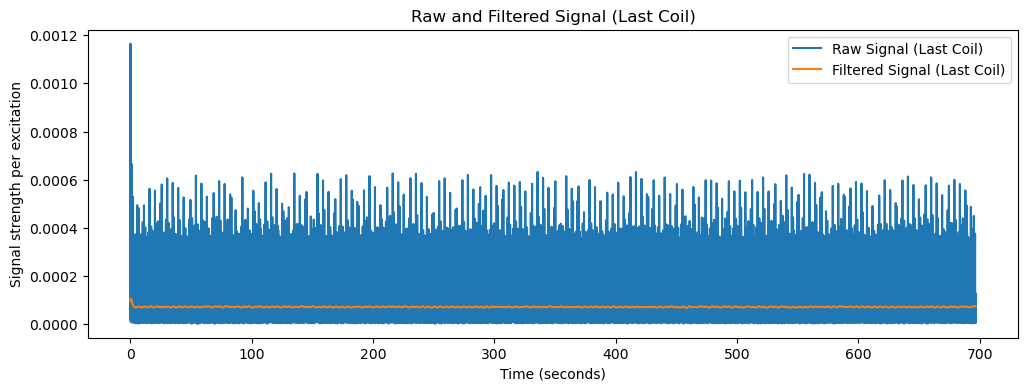

Explained variance ratio: [0.62771117]


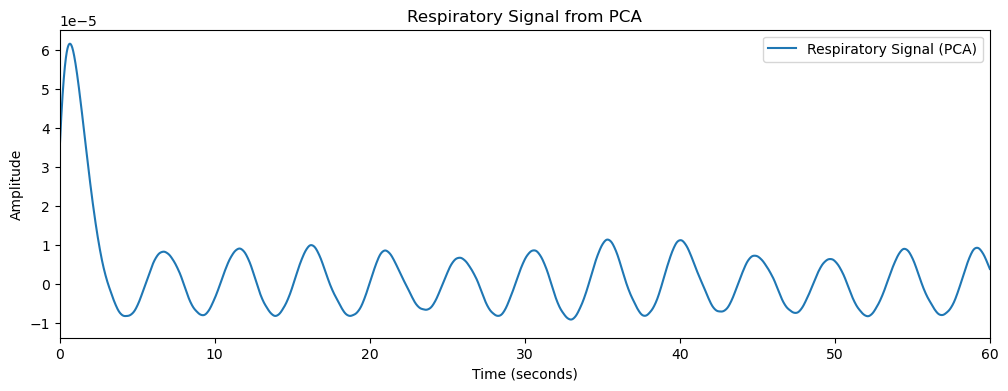

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.decomposition import PCA

def butter_lowpass_filter(data, cutoff_hz, fs_hz, order=2):
    nyq = 0.5 * fs_hz
    normal_cutoff = cutoff_hz / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def get_resp_signal(ksp_data, mapped):
    num_coils, num_slices, num_spokes, num_samples = ksp_data.shape

    TR = float(mapped[0]['hdr']['Config']['TR'])/1000000. ## microseconds to seconds
    print(f"TR from data: {TR} sec")

    n_samples = num_spokes * num_slices  # total time points/temporal samples

    # Sampling frequency in Hz
    fs = 1/(TR)
    print(f"Sampling frequency (Hz): {fs:.3f}")

    cutoff = 0.25  # respiratory frequency in Hz (~15 bpm)

    # Sanity check: cutoff must be less than Nyquist
    if cutoff >= fs / 2:
        cutoff = 0.49 * fs
        print(f"Cutoff frequency adjusted to: {cutoff:.3f} Hz to stay below Nyquist")

    # Build full time scale in SECONDS
    full_time_scale_s = np.arange(n_samples) * TR  # time in s
    print(f'full timescale goes to {full_time_scale_s[-1]}')

    signal_all_coils = []
    for c in range(num_coils):
        # mean magnitude over samples 130:140, shape (num_slices, num_spokes)
        signal = np.mean(np.abs(ksp_data[c, :, :, 130:140]), axis=-1)
        signal = signal.T.flatten()  # flatten to 1D (time points)

        filtered_signal = butter_lowpass_filter(signal, cutoff, fs, order=2)
        signal_all_coils.append(filtered_signal)

    coil_matrix = np.stack(signal_all_coils, axis=0)  # shape: (coils, time points)

    print(f"coil matrix shape: {coil_matrix.shape}")

    # plot raw and filtered signal from last coil as example (time in seconds)
    plt.figure(figsize=(12, 4))
    plt.plot(full_time_scale_s, signal, label="Raw Signal (Last Coil)")
    plt.plot(full_time_scale_s, signal_all_coils[-1], label="Filtered Signal (Last Coil)")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Signal strength per excitation")
    plt.title("Raw and Filtered Signal (Last Coil)")
    plt.legend()
    # plt.xlim(0, 60)  # show first 60 seconds
    plt.show()

    return coil_matrix, TR

def perform_pca(coil_matrix, n_components=1):
    # coil_matrix shape: (coils, time_points)
    data_for_pca = coil_matrix.T  # shape: (time_points, coils)
    pca = PCA(n_components=n_components)
    pcs = pca.fit_transform(data_for_pca)

    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
    return pcs, pca.explained_variance_ratio_

def plot_resp_signal(pcs, TR):
    n_samples = pcs.shape[0]
    time_ms = np.arange(n_samples) * TR
    plt.figure(figsize=(12, 4))
    plt.plot(time_ms, pcs[:, 0], label="Respiratory Signal (PCA)")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.title("Respiratory Signal from PCA")
    plt.legend()
    plt.xlim(0, 60)
    plt.show()

coil_matrix, TR = get_resp_signal(kspace_0, mapped)
pcs, _ = perform_pca(coil_matrix, n_components=1)
plot_resp_signal(pcs, TR)